In [1]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 3.8 MB/s 
     |████████████████████████████████| 61 kB 300 kB/s 
     |████████████████████████████████| 53 kB 786 kB/s 
     |████████████████████████████████| 1.6 MB 30.2 MB/s 
     |████████████████████████████████| 113 kB 88.9 MB/s 
     |████████████████████████████████| 47 kB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 47.5 MB/s 
     |████████████████████████████████| 959 kB 54.1 MB/s 
     |████████████████████████████████| 281 kB 62.7 MB/s 
     |████████████████████████████████| 636 kB 58.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: matpl

In [2]:
!pip install table-evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 7.2 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

import sdv.demo as demo
from sdv.tabular import CTGAN
from sdv.tabular import TVAE
from table_evaluator import load_data, TableEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult.csv


In [46]:
real_data = pd.read_csv('adult.csv')
real_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [47]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [48]:
real_data['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

In [49]:
real_data['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [50]:
numerical_columns = real_data.select_dtypes(['int64']).columns.to_list()
numerical_columns

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [51]:
def plot_boxplot(numerical_columns):
    plt.style.use('ggplot')
    sns.set_style('whitegrid')
    plt.figure(figsize = (20,10))
    i=0

    for feature in numerical_columns:
        i += 1
        plt.subplot(3,2,i)
        plt.boxplot(x = feature, data = real_data)

    plt.tight_layout()    
    plt.show() 

In [52]:
def plot_histogram(numerical_columns):
    plt.style.use('ggplot')
    sns.set_style('whitegrid')    
    plt.figure(figsize = (20,10))
    i=0

    for feature in numerical_columns:
        i += 1
        plt.subplot(3,2,i)
        sns.distplot(real_data[feature])

    plt.tight_layout()    
    plt.show()

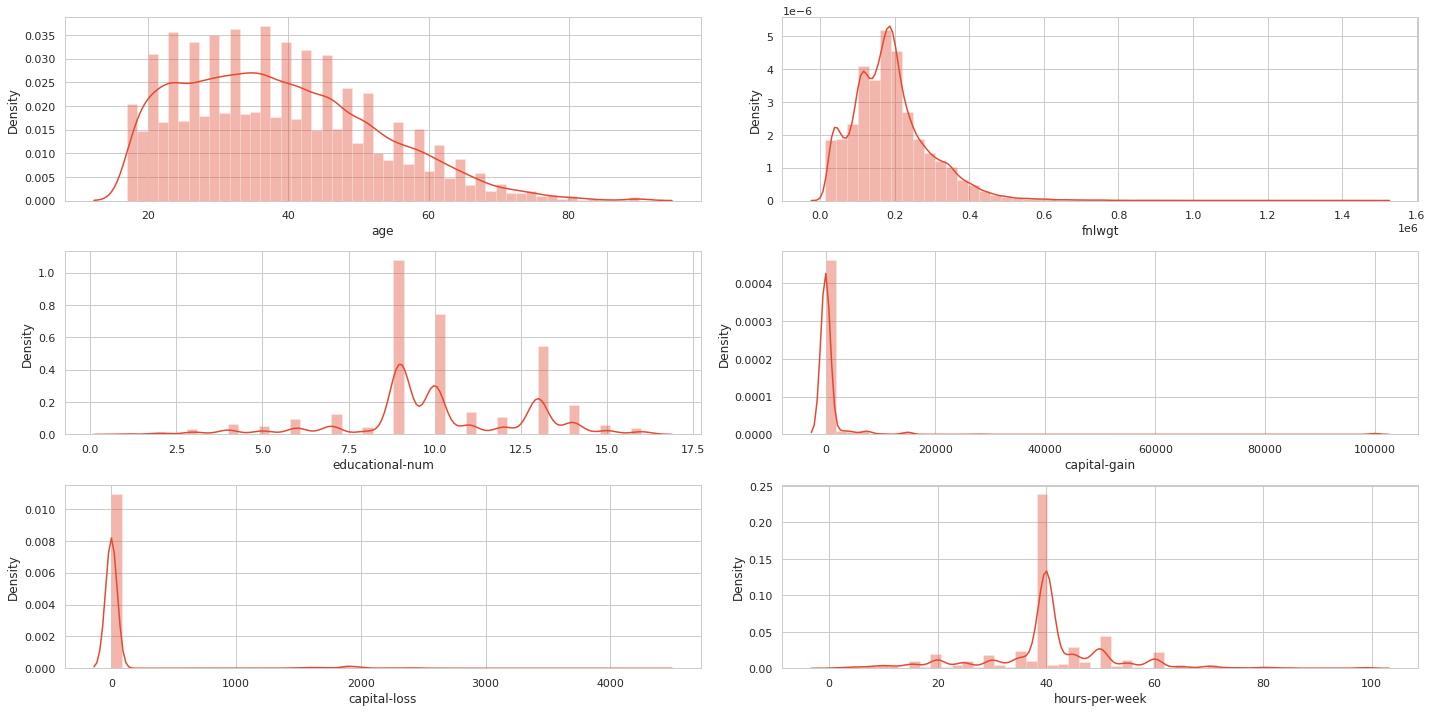

In [53]:
plot_histogram(numerical_columns)

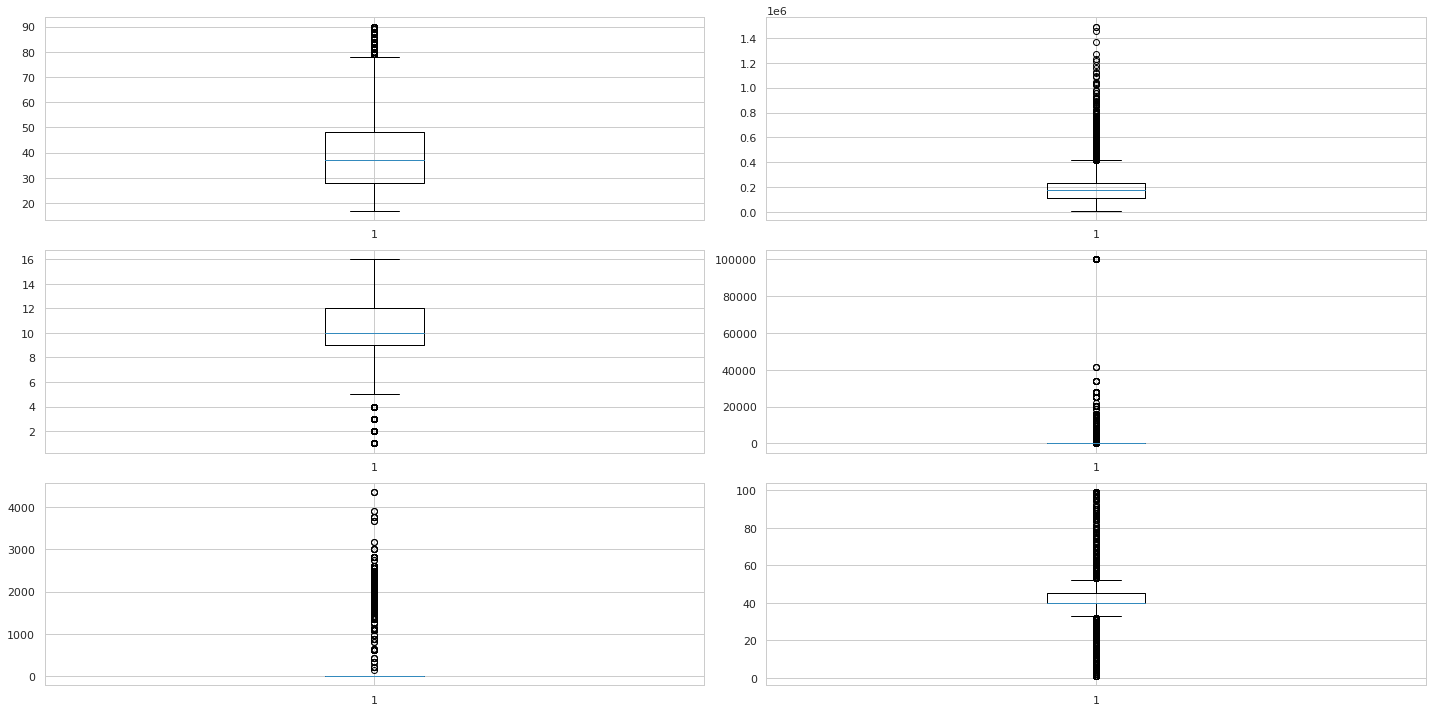

In [54]:
plot_boxplot(numerical_columns)

In [55]:
def remove_outliers(numerical_columns,real_data):
    for feature in numerical_columns:
        lower_critical_value = real_data[feature].mean() - 2 * real_data[feature].std()
        upper_critical_value = real_data[feature].mean() + 2 * real_data[feature].std()
        real_data = real_data[~((real_data[feature] < lower_critical_value) | (real_data[feature] > upper_critical_value))]  
        return real_data

In [56]:
real_data = remove_outliers(numerical_columns,real_data)
real_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


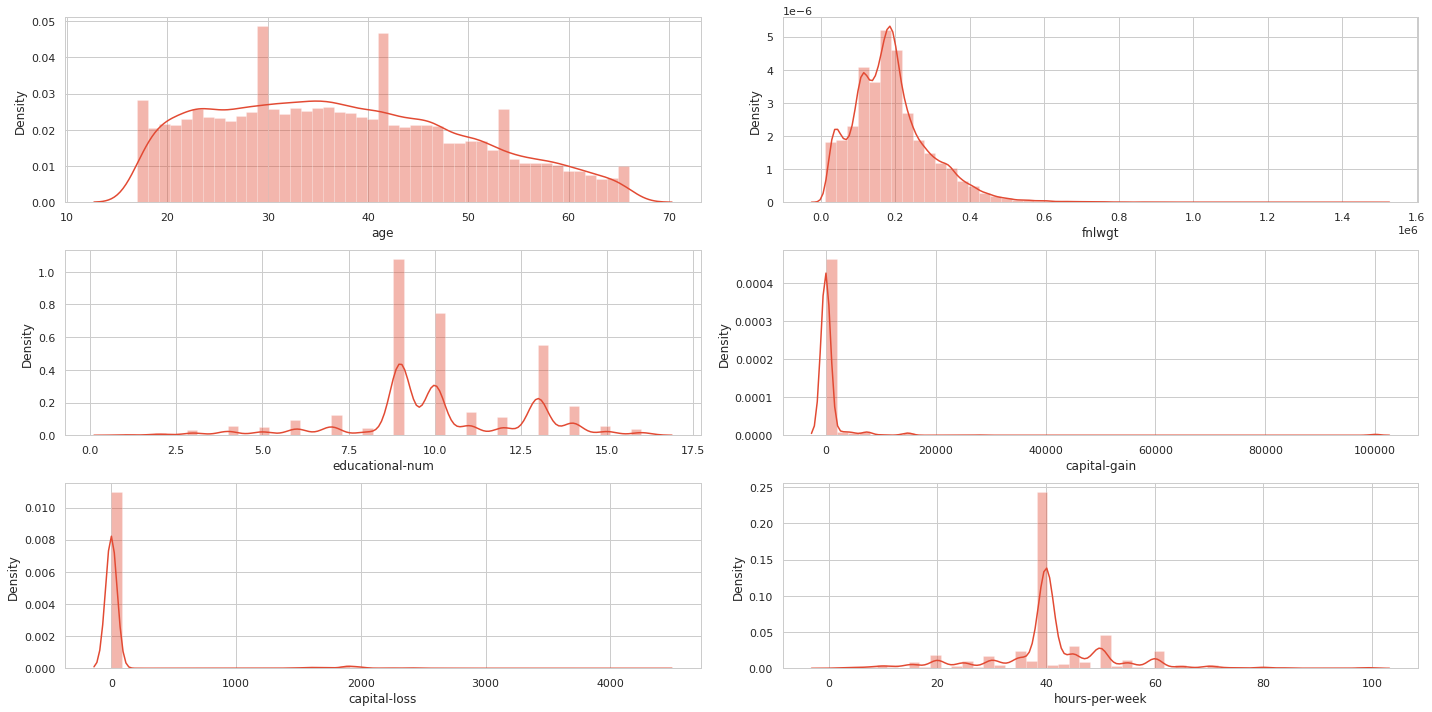

In [57]:
plot_histogram(numerical_columns)

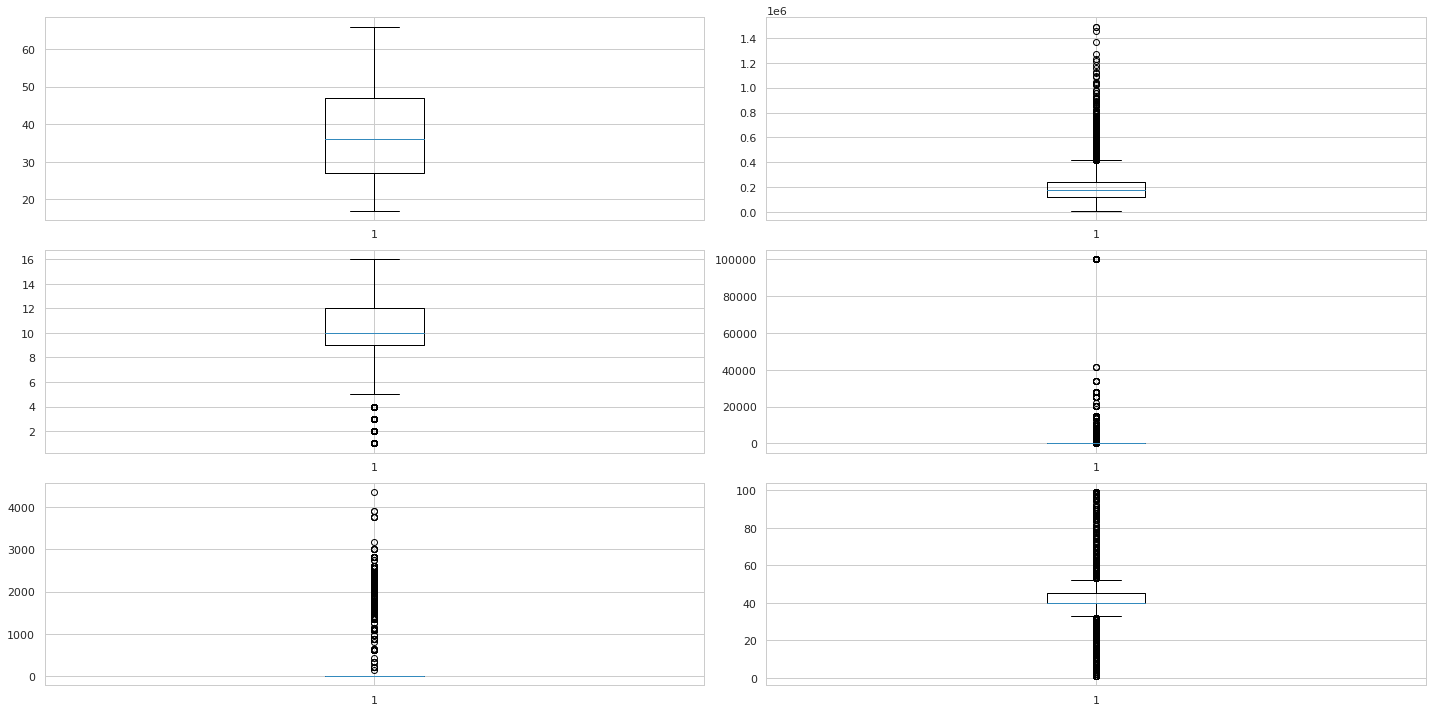

In [58]:
plot_boxplot(numerical_columns)

**Build GAN - 1**

In [59]:
model_gan = CTGAN(
              epochs=500,
              batch_size=100,
              generator_dim=(256, 256, 256),
              discriminator_dim=(256, 256, 256)
            )

In [60]:
model_gan.fit(real_data)

In [61]:
from sdv.sampling import Condition

condition_0 = Condition({      
        'income': '<=50K'
          }, num_rows=37155)

condition_1 = Condition({      
        'income': '>50K'
          }, num_rows=11687)

In [62]:
gan_0 = model_gan.sample_conditions(conditions=[condition_0])
gan_1 = model_gan.sample_conditions(conditions=[condition_1])

Sampling conditions: 100%|██████████| 11687/11687 [00:02<00:00, 3974.97it/s]


In [63]:
synthetic_data_gan = pd.concat([gan_0,gan_1])
synthetic_data_gan.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,35,Private,159980,12th,7,Married-civ-spouse,Other-service,Other-relative,Asian-Pac-Islander,Male,0,0,14,Dominican-Republic,<=50K
1,29,Private,267873,Some-college,10,Separated,Craft-repair,Not-in-family,Black,Female,0,0,47,Honduras,<=50K
2,53,Federal-gov,234921,HS-grad,9,Never-married,Adm-clerical,Unmarried,White,Female,0,0,55,United-States,<=50K
3,18,Private,262252,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,32,United-States,<=50K
4,29,Private,190355,Assoc-voc,11,Never-married,Craft-repair,Not-in-family,White,Male,2,0,40,Dominican-Republic,<=50K


In [64]:
synthetic_data_gan['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [65]:
synthetic_data_gan['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

Now, let’s check just how similar the synthetic data is to the real data. For this, we will use table_evaluator to visualize the difference between the fake and real data.

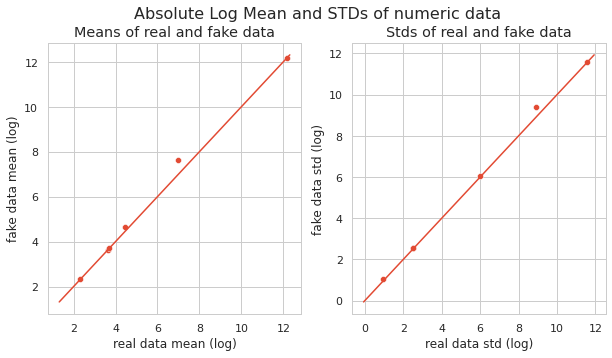

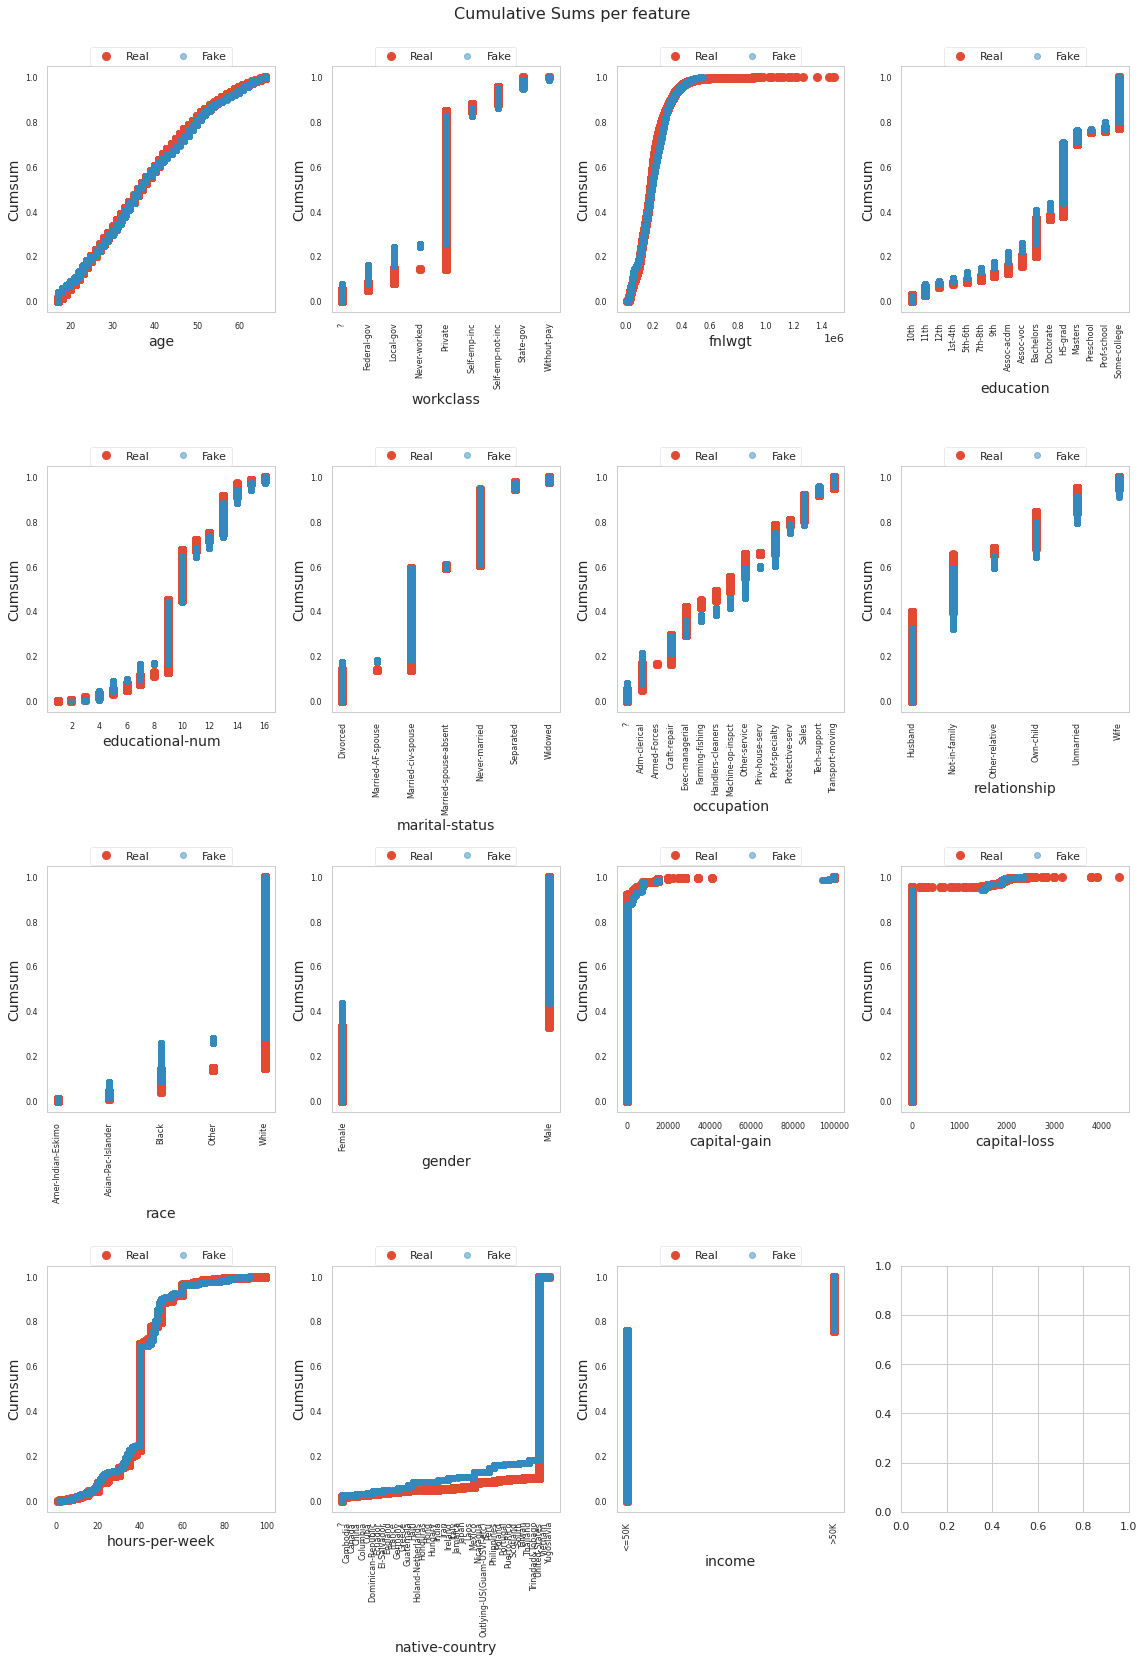

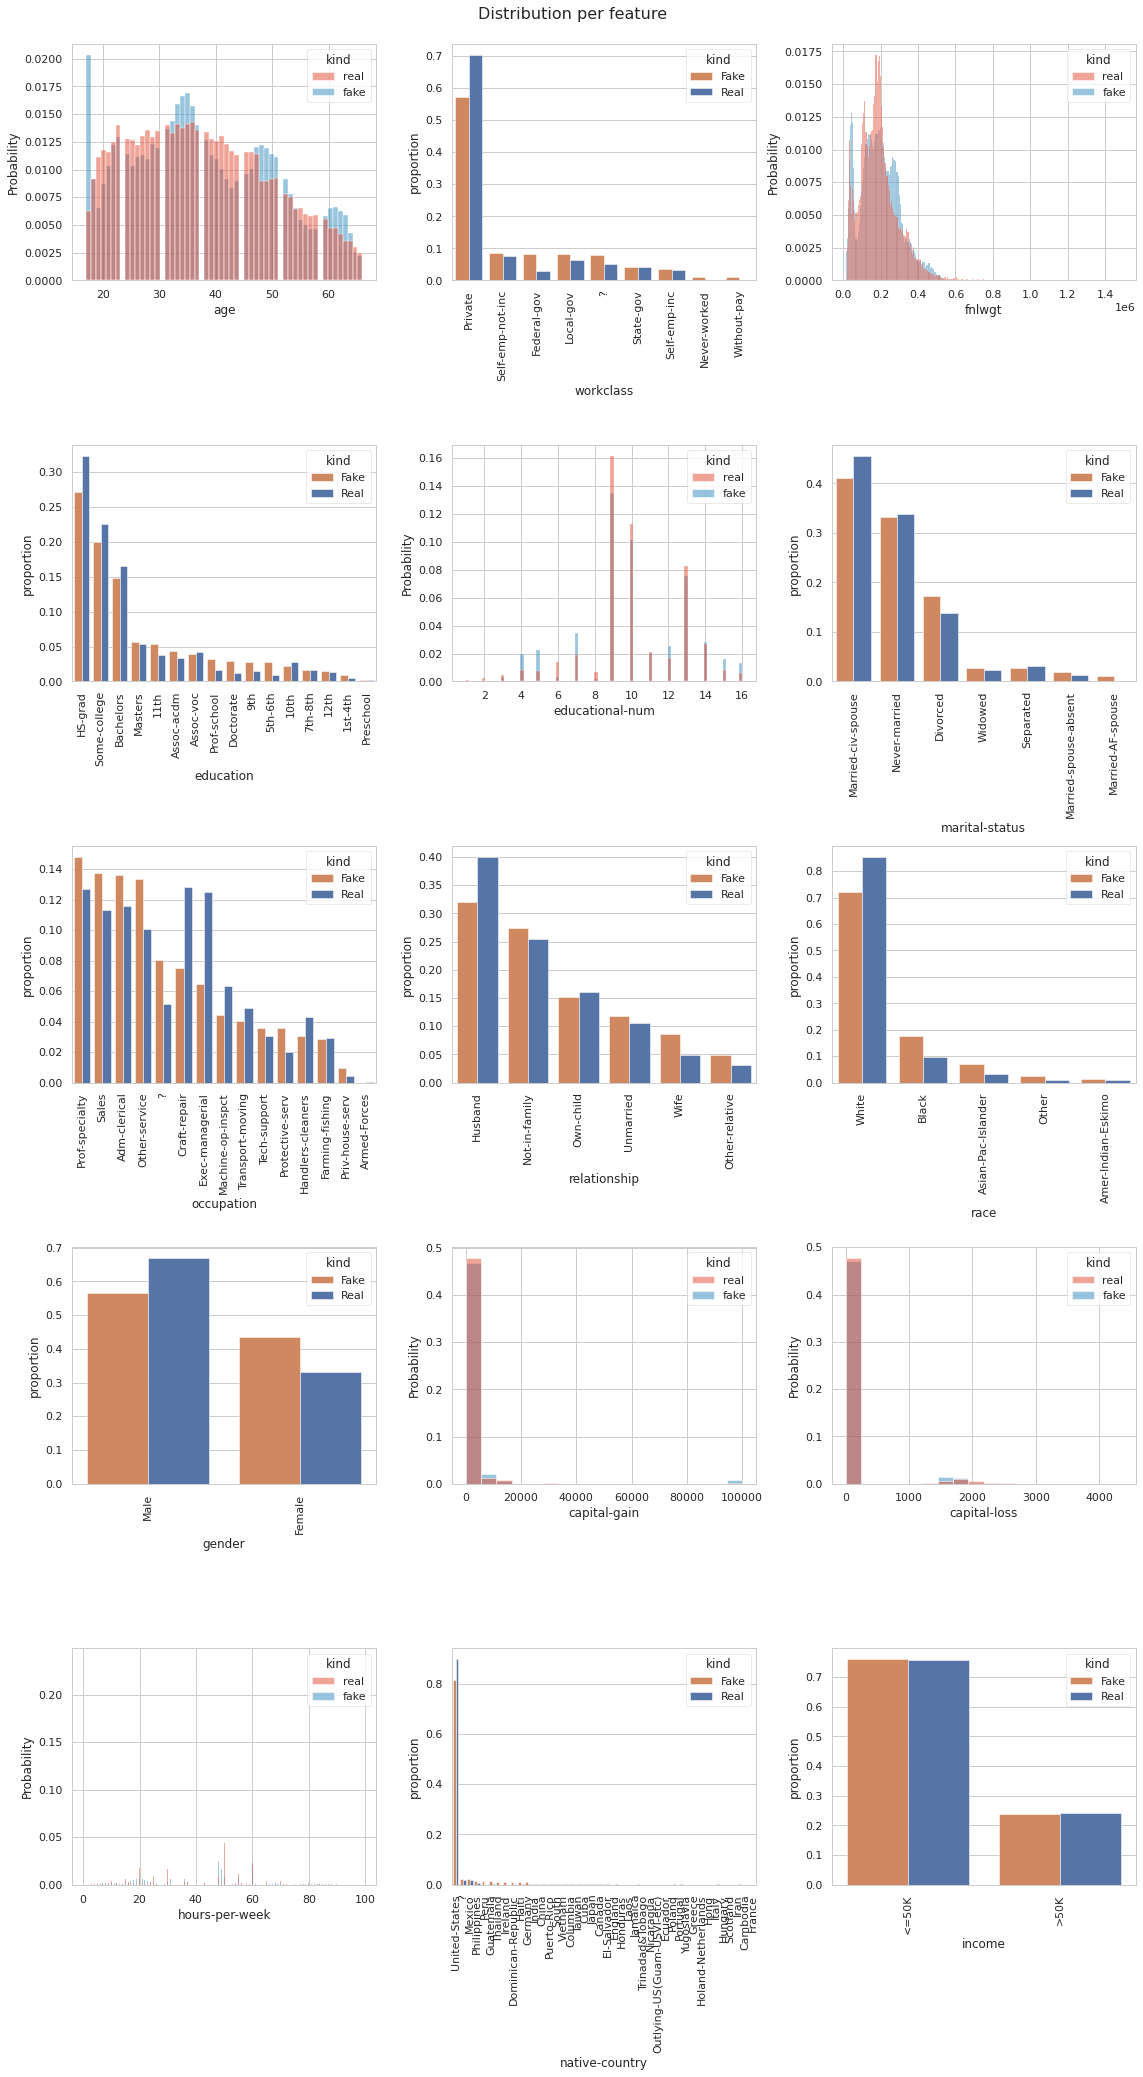

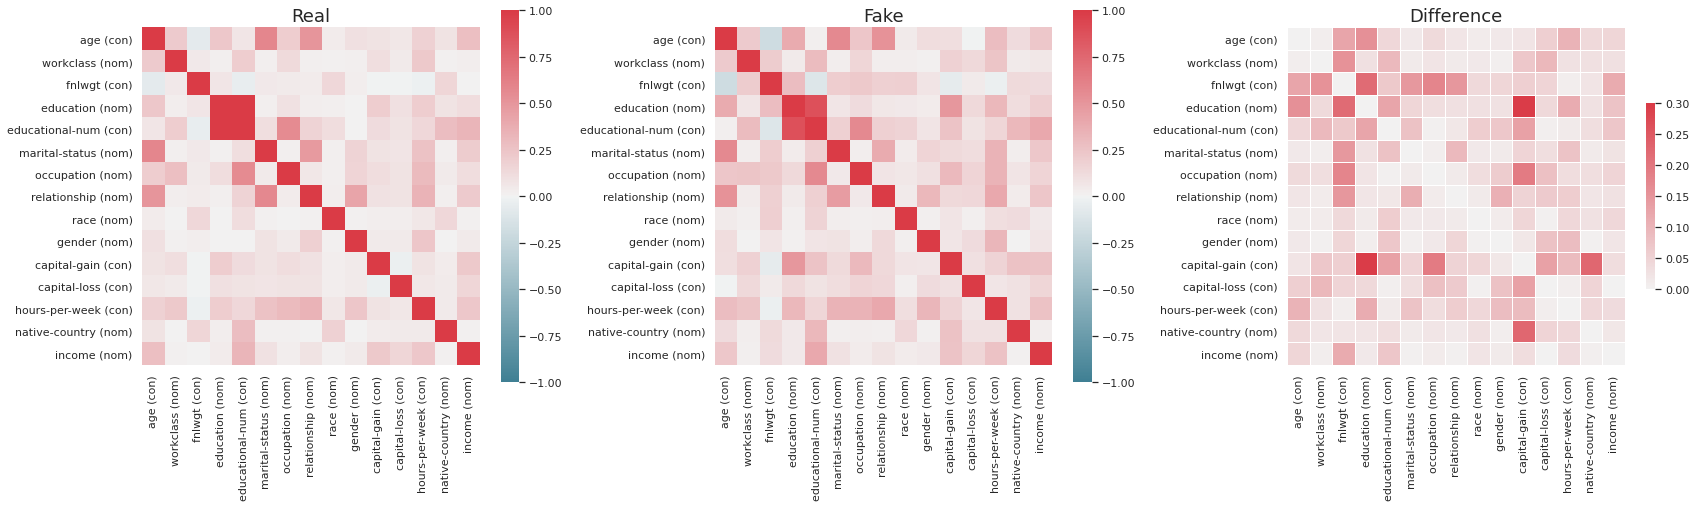

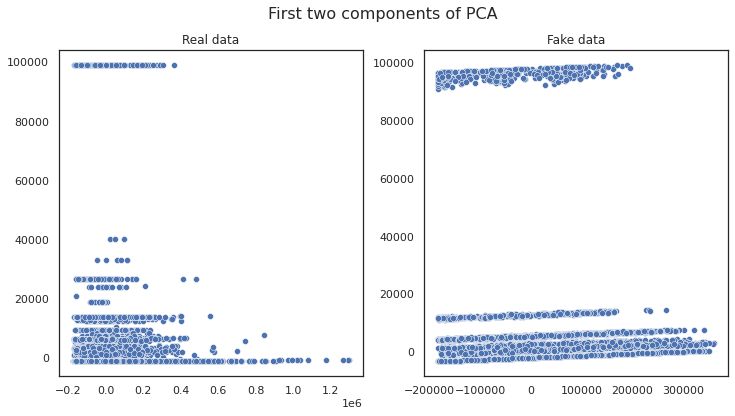

In [66]:
table_evaluator = TableEvaluator(real_data, synthetic_data_gan)
table_evaluator.visual_evaluation()

**Build GAN - 2**

In [67]:
model_gan_2 = CTGAN(
              epochs=500,
              batch_size=200,
              generator_dim=(256, 256, 256),
              discriminator_dim=(256, 256, 256)
            )

In [68]:
model_gan_2.fit(real_data)

In [69]:
from sdv.sampling import Condition

condition_0 = Condition({      
        'income': '<=50K'
          }, num_rows=37155)

condition_1 = Condition({      
        'income': '>50K'
          }, num_rows=11687)

In [70]:
gan_0 = model_gan_2.sample_conditions(conditions=[condition_0])
gan_1 = model_gan_2.sample_conditions(conditions=[condition_1])

Sampling conditions: 100%|██████████| 11687/11687 [00:02<00:00, 5368.76it/s]


In [71]:
synthetic_data_gan_2 = pd.concat([gan_0,gan_1])
synthetic_data_gan_2.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,Private,150702,HS-grad,9,Divorced,Other-service,Unmarried,Black,Female,0,0,20,United-States,<=50K
1,49,Federal-gov,221535,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15,0,40,Canada,<=50K
2,56,Local-gov,37737,Assoc-voc,11,Divorced,Prof-specialty,Not-in-family,White,Male,6,0,40,United-States,<=50K
3,35,Private,223538,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
4,54,Private,37339,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,1611,44,United-States,<=50K


In [73]:
synthetic_data_gan_2['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [74]:
synthetic_data_gan_2['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

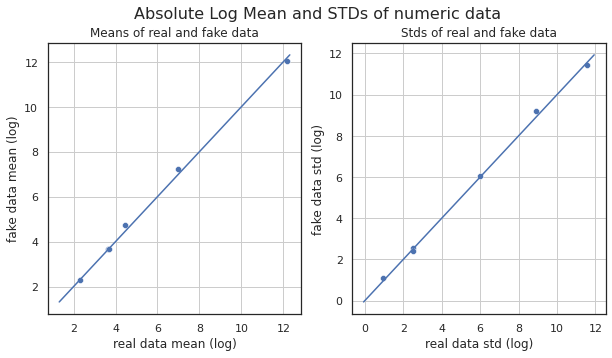

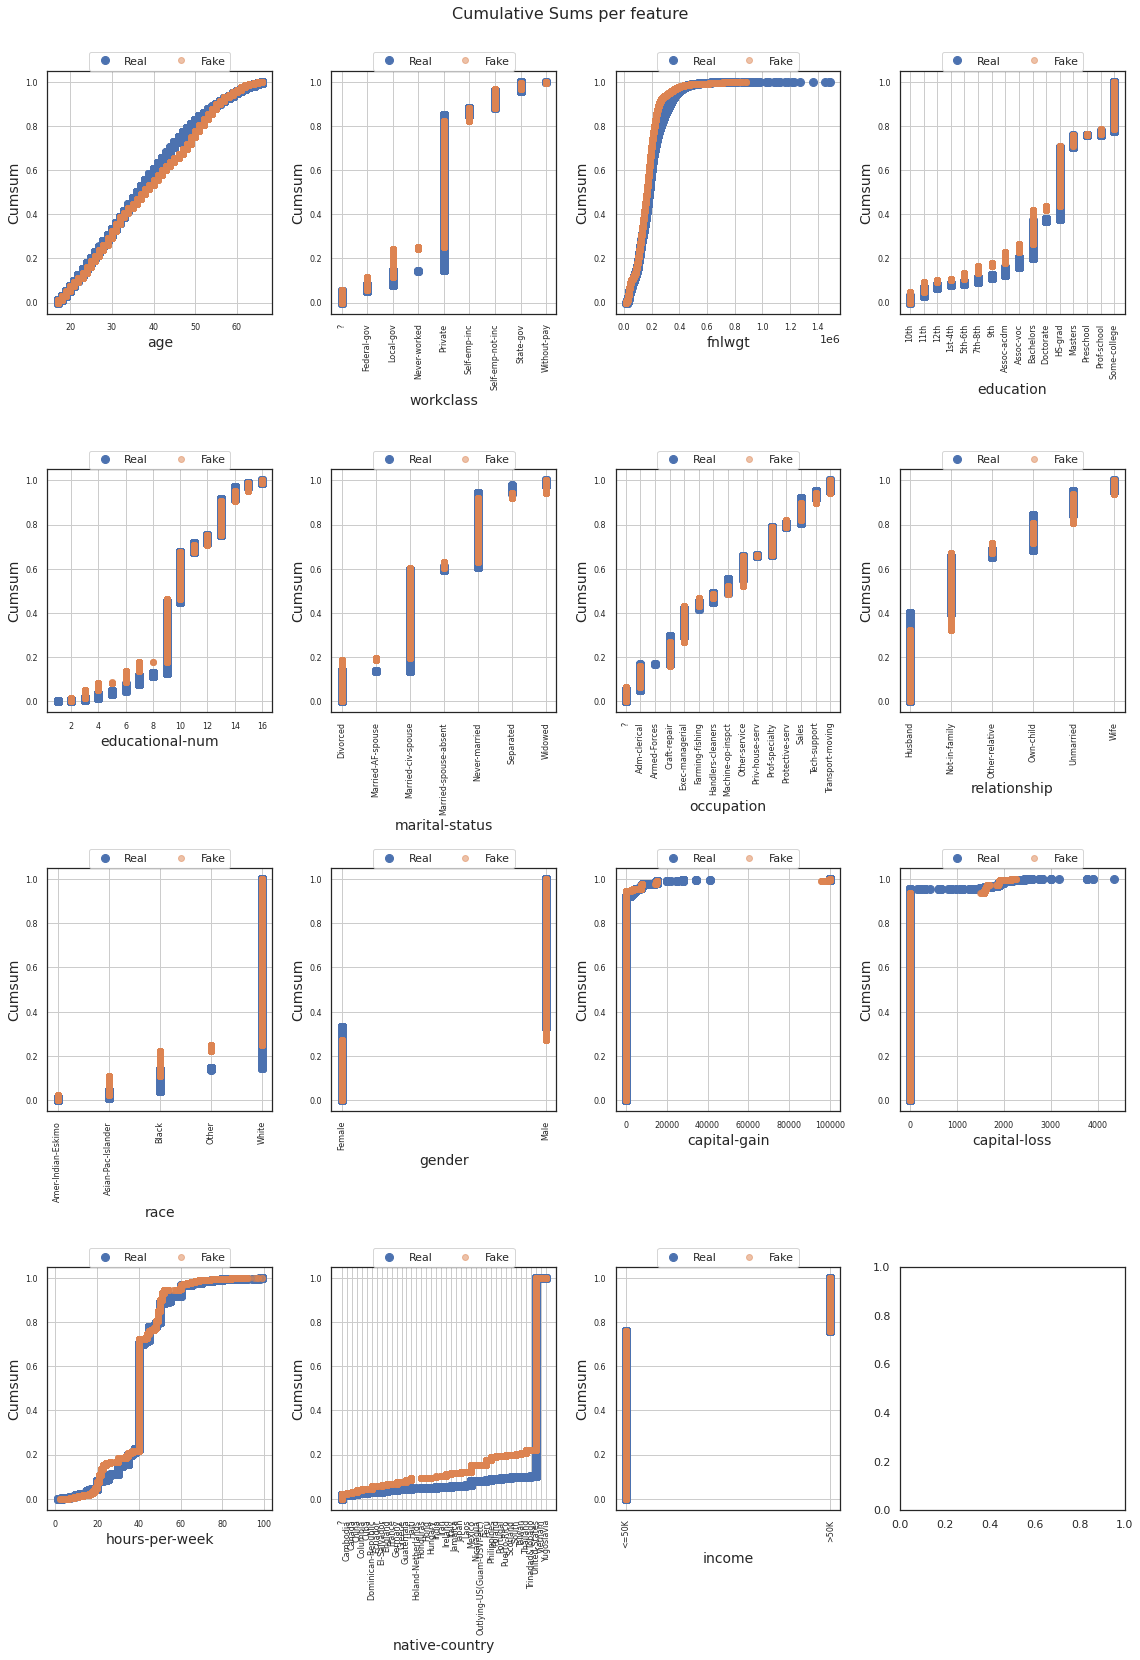

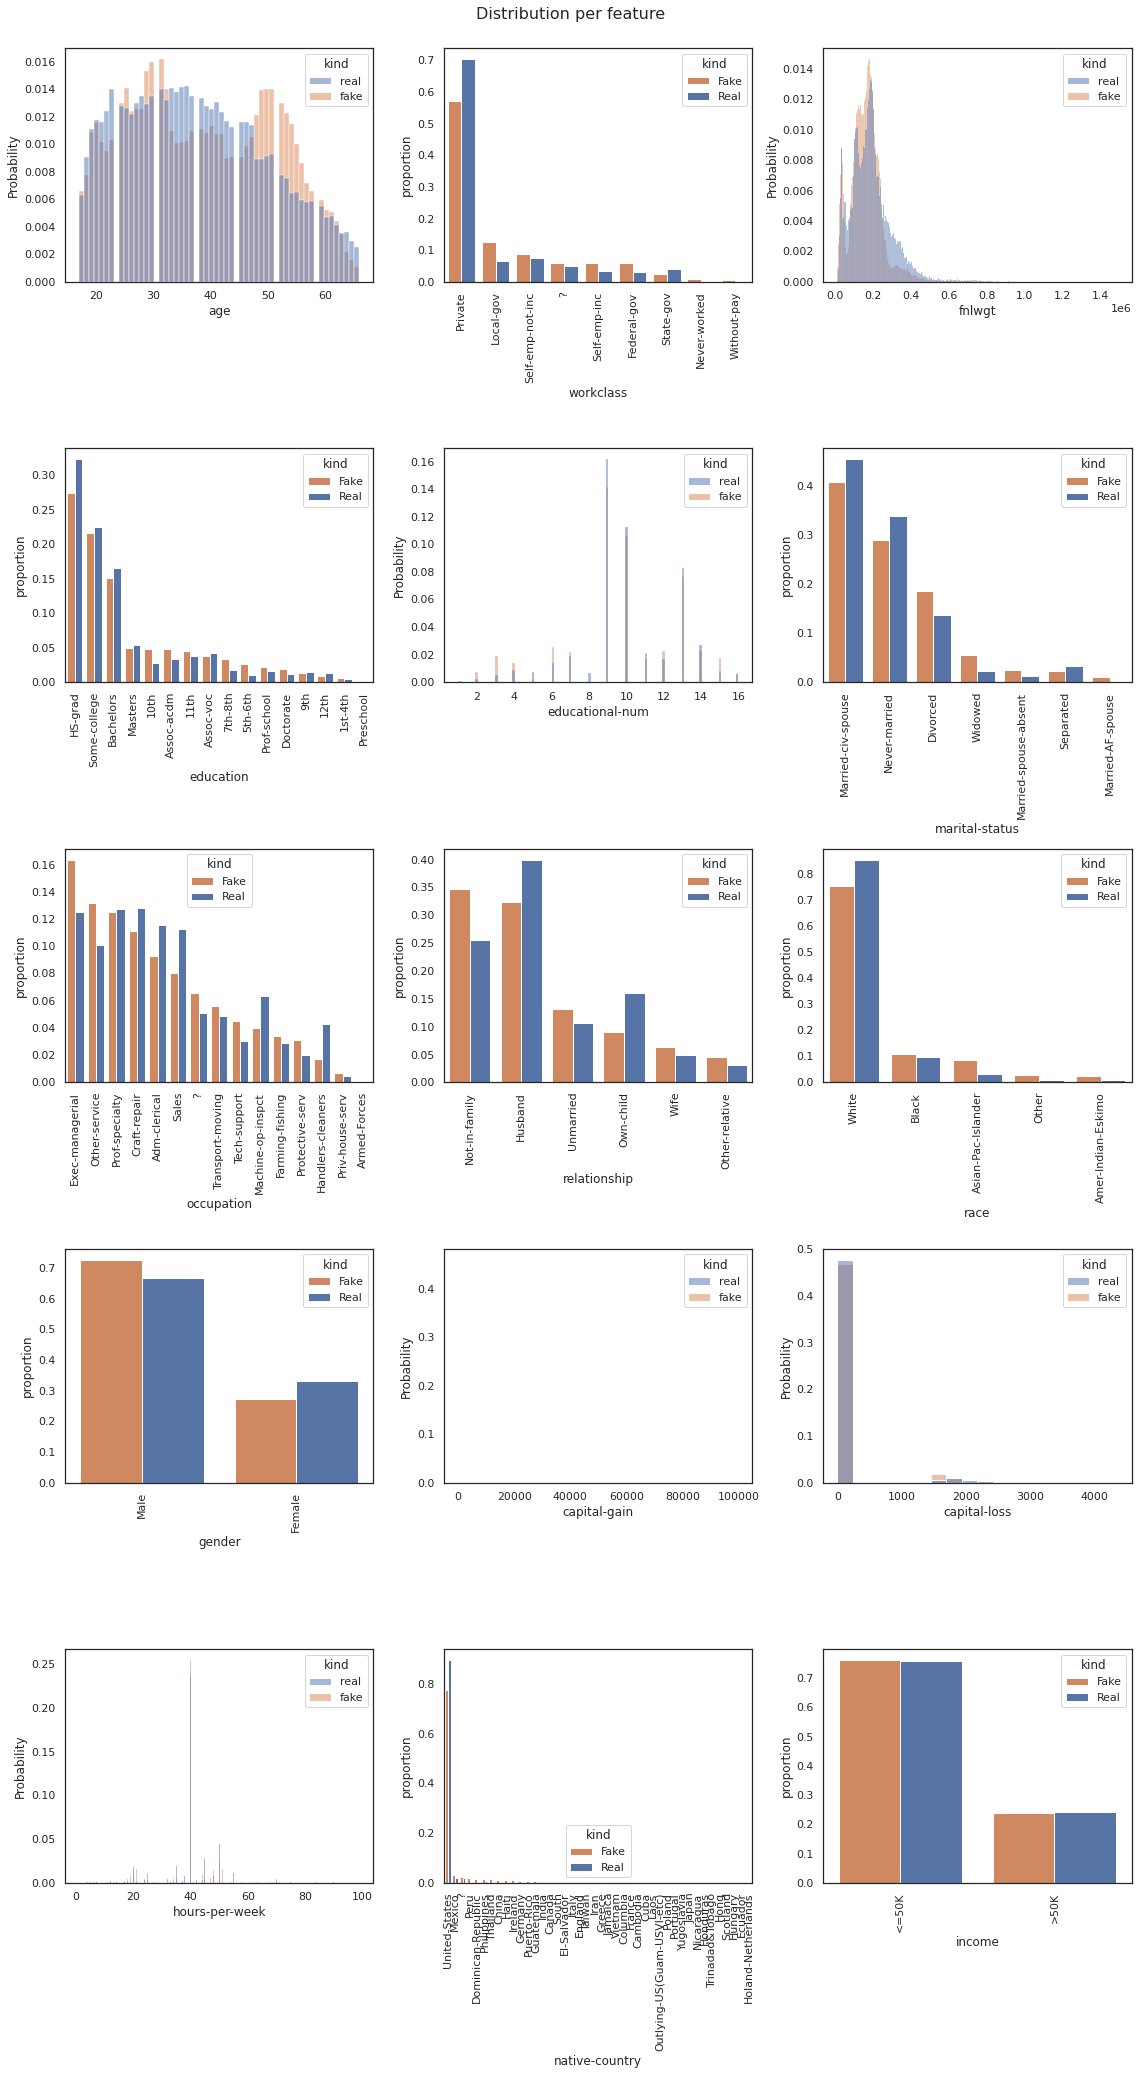

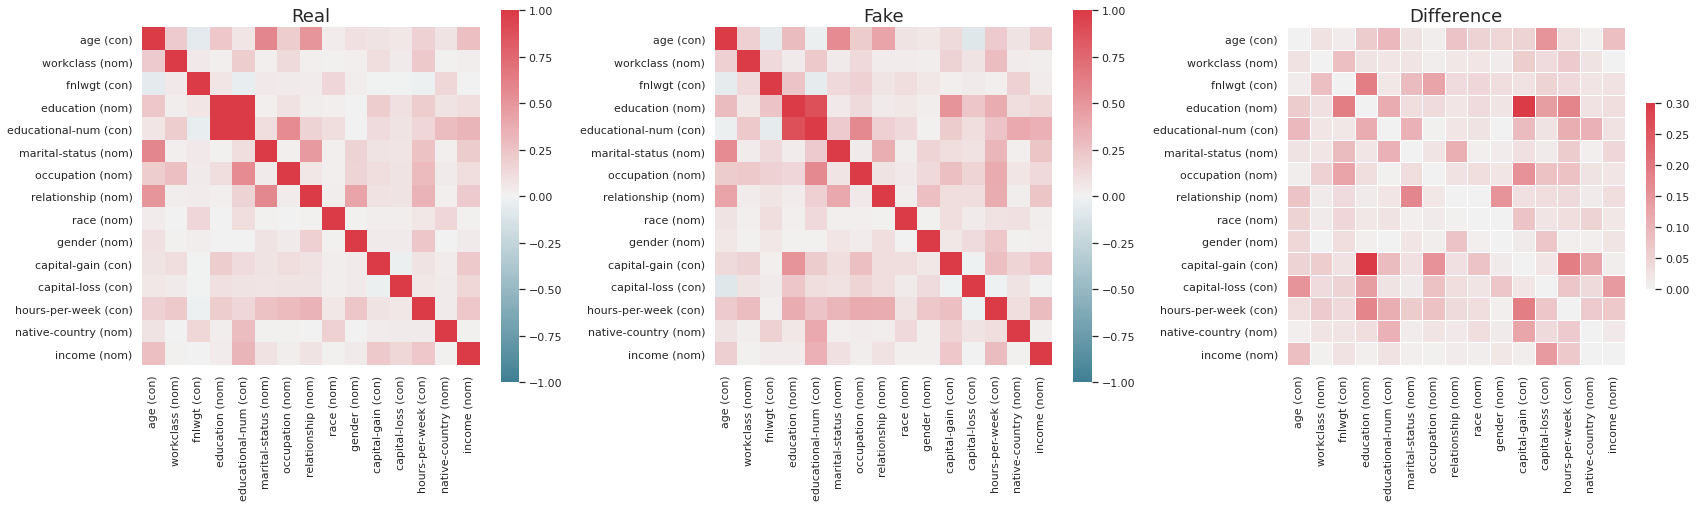

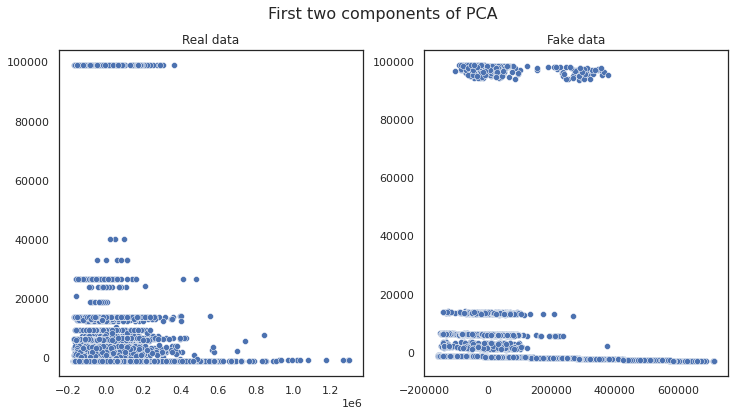

In [75]:
table_evaluator = TableEvaluator(real_data, synthetic_data_gan_2)
table_evaluator.visual_evaluation()